# K Nearest Neighbors Classifier

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../FeatureEngineering/MetaData/data6_&_odds.csv')
df.dropna(inplace=True)

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = df.loc[(df.season <= 2013) & (df.season >= 2007)]
valid_data = df.loc[(df.season > 2013) & (df.season < 2016)]
test_data = df.loc[df.season >= 2016]
full_train_data = pd.concat([train_data, valid_data], axis=0)

X_train, y_train = train_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), train_data.home_team_wins
X_val, y_val = valid_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), valid_data.home_team_wins
X_test, y_test = test_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), test_data.home_team_wins


## KNN with GridSearchCV and PCA

In [4]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
trainPCA = pca.fit_transform(X_train)
valPCA = pca.transform(X_val)

In [6]:
import time

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50)}

estimator = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(trainPCA, y_train)
# val_score = estimator.score(X_val, y_val)

preds = estimator.predict(valPCA)
val_score = estimator.score(valPCA, y_val)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)


Συνολικός χρόνος fit και predict: 34.99454975128174 seconds
              precision    recall  f1-score   support

   home_loss       0.70      0.40      0.51      1011
    home_win       0.67      0.87      0.76      1409

    accuracy                           0.68      2420
   macro avg       0.68      0.64      0.63      2420
weighted avg       0.68      0.68      0.65      2420

val score: 0.6760330578512397
KNeighborsClassifier(n_neighbors=45)
{'n_neighbors': 45}


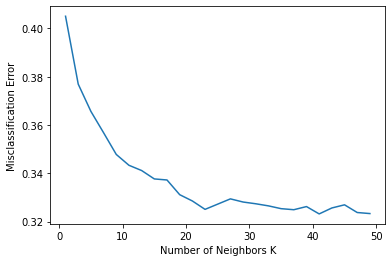

In [78]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, trainPCA, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [79]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(trainPCA, y_train)
pred = knn.predict(valPCA)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 41

Optimal accuracy on the test set is 0.6892561983471074 with k= 41


## Use of StandardScaler

In [7]:
from sklearn.preprocessing import StandardScaler

# Scaling features
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_val_standard = scaler.transform(X_val)
X_test_standard = scaler.transform(X_test)

In [8]:
import time

# Split Data to Train and Validation
# X_train, X_val, y_train, y_val = train_test_split(X_train_standard, y_train, test_size=0.4)
clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_standard, y_train)
val_score = estimator.score(X_val_standard, y_val)

preds = estimator.predict(X_val_standard)
test_score = estimator.score(X_val_standard, y_val)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 146.79847598075867 seconds
              precision    recall  f1-score   support

   home_loss       0.64      0.53      0.58      1011
    home_win       0.70      0.79      0.74      1409

    accuracy                           0.68      2420
   macro avg       0.67      0.66      0.66      2420
weighted avg       0.68      0.68      0.68      2420

val score: 0.6809917355371901
KNeighborsClassifier(leaf_size=1, n_neighbors=48)
{'leaf_size': 1, 'n_neighbors': 48}
best score: 0.6742028985507246
test score 0.6809917355371901


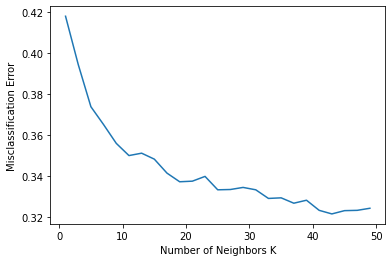

In [18]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_standard, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [19]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_standard, y_train)
pred = knn.predict(X_val_standard)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 43

Optimal accuracy on the test set is 0.6863636363636364 with k= 43


## Use of MinMax Scaler

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Scaling features
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_val_minmax = scaler.transform(X_val)
X_test_minmax = scaler.transform(X_test)


In [10]:
import time

# Split Data to Train and Validation
# X_train, X_val, y_train, y_val = train_test_split(X_train_minmax, y_train, test_size=0.4)
clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_minmax, y_train)
val_score = estimator.score(X_val_minmax, y_val)

preds = estimator.predict(X_val_minmax)
# test_score = estimator.score(X_test_minmax, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
# print("test score", test_score)



Συνολικός χρόνος fit και predict: 129.24791646003723 seconds
              precision    recall  f1-score   support

   home_loss       0.66      0.47      0.55      1011
    home_win       0.68      0.82      0.75      1409

    accuracy                           0.68      2420
   macro avg       0.67      0.65      0.65      2420
weighted avg       0.67      0.68      0.66      2420

val score: 0.675206611570248
KNeighborsClassifier(leaf_size=1, n_neighbors=49)
{'leaf_size': 1, 'n_neighbors': 49}
best score: 0.6769565217391305


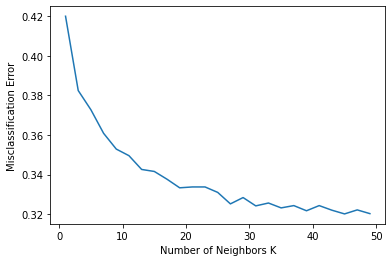

In [82]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_minmax, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [83]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_minmax, y_train)
pred = knn.predict(X_val_minmax)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 45

Optimal accuracy on the test set is 0.6785123966942149 with k= 45


## Univariate Feature Selection

In [11]:
X_train_uni = train_data[['diff_curr_win_pct','diff_curr_away_record','odds_home','odds_away','elo_diff']]
y_train_uni = y_train

X_val_uni = valid_data[['diff_curr_win_pct','diff_curr_away_record','odds_home','odds_away','elo_diff']]
y_val_uni = y_val

In [12]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_uni, y_train_uni)
val_score = estimator.score(X_val_uni, y_val_uni)

preds = estimator.predict(X_val_uni)
test_score = estimator.score(X_val_uni, y_val_uni)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_uni, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 18.1750648021698 seconds
              precision    recall  f1-score   support

   home_loss       0.63      0.52      0.57      1011
    home_win       0.69      0.78      0.73      1409

    accuracy                           0.67      2420
   macro avg       0.66      0.65      0.65      2420
weighted avg       0.67      0.67      0.67      2420

val score: 0.671900826446281
KNeighborsClassifier(leaf_size=1, n_neighbors=23)
{'leaf_size': 1, 'n_neighbors': 23}
best score: 0.6752173913043478
test score 0.671900826446281


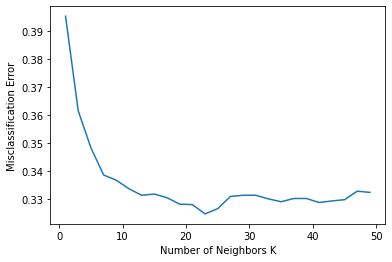

In [21]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_uni, y_train_uni, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [22]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_uni, y_train_uni)
pred = knn.predict(X_val_uni)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_uni, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 23

Optimal accuracy on the test set is 0.671900826446281 with k= 23


## kNN with ExtraTress Classifier

In [15]:
X_train_extra = train_data[['odds_home', 'odds_away', 'home_elo', 'visitor_elo', 'elo_diff',
                    'eff_diff', 'eff_visitor', 'top_player_diff', 'diff_win_pct_prev_season',
                    'diff_home_record_last_season', 'ROAD_RECORD_home',
                    'diff_road_record_last_season', 'diff_win_pct_7_last_games', 'W_PCT_home',
                    'W_PCT_away', 'W_PCT_prev_away', 'diff_curr_away_record', 'HOME_RECORD_home', 'diff_curr_home_record',
                    'diff_curr_win_pct']]
y_train_extra = y_train

X_val_extra = valid_data[['odds_home', 'odds_away', 'home_elo', 'visitor_elo', 'elo_diff',
                    'eff_diff', 'eff_visitor', 'top_player_diff', 'diff_win_pct_prev_season',
                    'diff_home_record_last_season', 'ROAD_RECORD_home',
                    'diff_road_record_last_season', 'diff_win_pct_7_last_games', 'W_PCT_home',
                    'W_PCT_away', 'W_PCT_prev_away', 'diff_curr_away_record', 'HOME_RECORD_home', 'diff_curr_home_record',
                    'diff_curr_win_pct']]
y_val_extra = y_val

In [16]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_extra, y_train_extra)
val_score = estimator.score(X_val_extra, y_val_extra)

preds = estimator.predict(X_val_extra)
test_score = estimator.score(X_val_extra, y_val_extra)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_extra, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 113.84671521186829 seconds
              precision    recall  f1-score   support

   home_loss       0.67      0.53      0.59      1011
    home_win       0.70      0.81      0.75      1409

    accuracy                           0.69      2420
   macro avg       0.69      0.67      0.67      2420
weighted avg       0.69      0.69      0.68      2420

val score: 0.6921487603305785
KNeighborsClassifier(leaf_size=1, n_neighbors=49)
{'leaf_size': 1, 'n_neighbors': 49}
best score: 0.6771014492753623
test score 0.6921487603305785


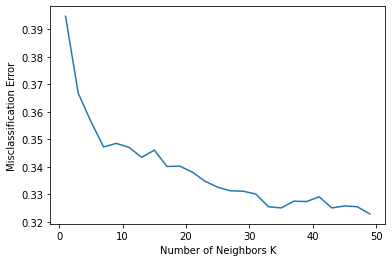

In [25]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_extra, y_train_extra, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [26]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_extra, y_train_extra)
pred = knn.predict(X_val_extra)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_extra, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6921487603305785 with k= 49


## Reduce Extra Trees features with high correlation

In [12]:
X_train_extra = train_data[['odds_home', 'odds_away', 'home_elo', 'visitor_elo',
                    'eff_diff', 'eff_visitor', 'top_player_diff', 'diff_win_pct_prev_season',
                    'diff_win_pct_7_last_games', 'W_PCT_home',
                    'W_PCT_away']]
y_train_extra = y_train

X_val_extra = valid_data[['odds_home', 'odds_away', 'home_elo', 'visitor_elo',
                    'eff_diff', 'eff_visitor', 'top_player_diff', 'diff_win_pct_prev_season',
                    'diff_win_pct_7_last_games', 'W_PCT_home',
                    'W_PCT_away']]
y_val_extra = y_val

In [13]:
from sklearn.preprocessing import StandardScaler

# Scaling features
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train_extra)
X_val_standard = scaler.transform(X_val_extra)

In [14]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50)}

estimator = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_standard, y_train_extra)
val_score = estimator.score(X_val_standard, y_val_extra)

preds = estimator.predict(X_val_standard)
test_score = estimator.score(X_val_standard, y_val_extra)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_extra, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 10.894787549972534 seconds
              precision    recall  f1-score   support

   home_loss       0.66      0.52      0.59      1011
    home_win       0.70      0.81      0.75      1409

    accuracy                           0.69      2420
   macro avg       0.68      0.67      0.67      2420
weighted avg       0.69      0.69      0.68      2420

val score: 0.6904958677685951
KNeighborsClassifier(n_neighbors=49)
{'n_neighbors': 49}
best score: 0.6833333333333332
test score 0.6904958677685951


In [15]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 100)}

estimator = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_standard, y_train_extra)
val_score = estimator.score(X_val_standard, y_val_extra)

preds = estimator.predict(X_val_standard)
test_score = estimator.score(X_val_standard, y_val_extra)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_extra, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 28.49450373649597 seconds
              precision    recall  f1-score   support

   home_loss       0.67      0.53      0.59      1011
    home_win       0.71      0.81      0.75      1409

    accuracy                           0.69      2420
   macro avg       0.69      0.67      0.67      2420
weighted avg       0.69      0.69      0.69      2420

val score: 0.693801652892562
KNeighborsClassifier(n_neighbors=72)
{'n_neighbors': 72}
best score: 0.6849275362318841
test score 0.693801652892562


## kNN with SelectFromModel(LassoCV)

In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline

In [28]:
pipe_model = Pipeline([
  ('feature_selection', SelectFromModel(LassoCV())),
  ('classification', KNeighborsClassifier(leaf_size=1, n_neighbors=13))
])
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', SelectFromModel(estimator=LassoCV())),
                ('classification',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=13))])

In [29]:
# Predict
preds = pipe_model.predict(X_val)
test_score = pipe_model.score(X_val, y_val)

target_names=['home loss', 'home win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))

print("test score", test_score)


Συνολικός χρόνος fit και predict: 437.4017581939697 seconds
              precision    recall  f1-score   support

   home loss       0.63      0.53      0.58      1011
    home win       0.70      0.78      0.74      1409

    accuracy                           0.68      2420
   macro avg       0.67      0.65      0.66      2420
weighted avg       0.67      0.68      0.67      2420

test score 0.675206611570248


#### Use lasso_data

In [44]:
X_train_sfm = train_data[['elo_diff', 'odds_away', 'odds_home', 'eff_diff', 'eff_visitor',
              'missing_players', 'top_players', 'FT_PCT_home_7g', 'diff_avg_reb_away',
              'home_elo']]
y_train_sfm = y_train

X_val_sfm = valid_data[['elo_diff', 'odds_away', 'odds_home', 'eff_diff', 'eff_visitor',
              'missing_players', 'top_players', 'FT_PCT_home_7g', 'diff_avg_reb_away',
              'home_elo']]
y_val_sfm = y_val

In [31]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_sfm, y_train_sfm)
val_score = estimator.score(X_val_sfm, y_val_sfm)

preds = estimator.predict(X_val_sfm)
test_score = estimator.score(X_val_sfm, y_val_sfm)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_sfm, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 11.302307367324829 seconds
              precision    recall  f1-score   support

   home_loss       0.62      0.53      0.57      1011
    home_win       0.69      0.77      0.73      1409

    accuracy                           0.67      2420
   macro avg       0.66      0.65      0.65      2420
weighted avg       0.67      0.67      0.66      2420

val score: 0.6698347107438016
KNeighborsClassifier(leaf_size=1, n_neighbors=11)
{'leaf_size': 1, 'n_neighbors': 11}
best score: 0.6534782608695653
test score 0.6698347107438016


In [32]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_sfm, y_train_sfm)
pred = knn.predict(X_val_sfm)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_sfm, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6847107438016529 with k= 49


## kNN with Sequential Feature Selection

### Forward

In [45]:
X_train_for_sfs = train_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'HOME_RECORD_home',
                    'W_PCT_away', 'W_PCT_prev_home', 'ROAD_RECORD_prev_home', 'W_PCT_prev_away',
                    'HOME_RECORD_prev_away', 'ROAD_RECORD_prev_away', 'WIN_PRCT_home_3g',
                    'FT_PCT_home_3g', 'FT_PCT_away_3g', 'FG3_PCT_away_3g', 'WIN_PRCT_home_7g',
                    'FT_PCT_away_7g', 'REB_away_7g', 'diff_avg_ast_home', 'diff_avg_ast_away',
                    'diff_avg_fg3_pct_home', 'diff_avg_fg_pct_away', 'diff_avg_reb_away',
                    'top_players', 'eff', 'eff_visitor', 'G_7days', 'back2back',
                    'HG_7days_VISITOR', 'AG_7days_VISITOR', 'G_7days_VISITOR',
                    'back2back_visitor', 'missing_players', 'missing_players_visitor',
                    'home_elo', 'elo_diff', 'missing_player_diff', 'eff_diff',
                    'Home_Last_5_Avg_FG3_PCT_home', 'Home_Last_5_Avg_FG3_PCT_away',
                    'Away_Last_5_Avg_FG3_PCT_home', 'Away_Last_5_Avg_FT_PCT_away',
                    'diff_fg_pct_last_3_games', 'diff_fg3_pct_last_7_games',
                    'diff_ft_pct_last_3_games', 'diff_ast_last_3_games',
                    'diff_ast_last_7_games', 'diff_win_pct_prev_season',
                    'diff_home_record_last_season', 'diff_road_record_last_season',
                    'diff_curr_win_pct']]

y_train_for_sfs = y_train

X_val_for_sfs = valid_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'HOME_RECORD_home',
                    'W_PCT_away', 'W_PCT_prev_home', 'ROAD_RECORD_prev_home', 'W_PCT_prev_away',
                    'HOME_RECORD_prev_away', 'ROAD_RECORD_prev_away', 'WIN_PRCT_home_3g',
                    'FT_PCT_home_3g', 'FT_PCT_away_3g', 'FG3_PCT_away_3g', 'WIN_PRCT_home_7g',
                    'FT_PCT_away_7g', 'REB_away_7g', 'diff_avg_ast_home', 'diff_avg_ast_away',
                    'diff_avg_fg3_pct_home', 'diff_avg_fg_pct_away', 'diff_avg_reb_away',
                    'top_players', 'eff', 'eff_visitor', 'G_7days', 'back2back',
                    'HG_7days_VISITOR', 'AG_7days_VISITOR', 'G_7days_VISITOR',
                    'back2back_visitor', 'missing_players', 'missing_players_visitor',
                    'home_elo', 'elo_diff', 'missing_player_diff', 'eff_diff',
                    'Home_Last_5_Avg_FG3_PCT_home', 'Home_Last_5_Avg_FG3_PCT_away',
                    'Away_Last_5_Avg_FG3_PCT_home', 'Away_Last_5_Avg_FT_PCT_away',
                    'diff_fg_pct_last_3_games', 'diff_fg3_pct_last_7_games',
                    'diff_ft_pct_last_3_games', 'diff_ast_last_3_games',
                    'diff_ast_last_7_games', 'diff_win_pct_prev_season',
                    'diff_home_record_last_season', 'diff_road_record_last_season',
                    'diff_curr_win_pct']]

y_val_for_sfs = y_val


In [34]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_for_sfs, y_train_for_sfs)
val_score = estimator.score(X_val_for_sfs, y_val_for_sfs)

preds = estimator.predict(X_val_for_sfs)
test_score = estimator.score(X_val_for_sfs, y_val_for_sfs)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_for_sfs, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 37.01522445678711 seconds
              precision    recall  f1-score   support

   home_loss       0.62      0.52      0.57      1011
    home_win       0.69      0.77      0.73      1409

    accuracy                           0.67      2420
   macro avg       0.66      0.65      0.65      2420
weighted avg       0.66      0.67      0.66      2420

val score: 0.6661157024793388
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6571014492753623
test score 0.6661157024793388


In [35]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_for_sfs, y_train_for_sfs)
pred = knn.predict(X_val_for_sfs)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_for_sfs, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6851239669421487 with k= 49


### Backwards

In [46]:
X_train_back_sfs = train_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'HOME_RECORD_home',
                     'W_PCT_away', 'W_PCT_prev_away', 'HOME_RECORD_prev_away',
                     'ROAD_RECORD_prev_away', 'FT_PCT_home_3g', 'FG3_PCT_home_3g', 'PTS_away_3g',
                     'FG_PCT_away_3g', 'FT_PCT_away_3g', 'FG3_PCT_away_3g', 'PTS_home_7g',
                     'FG_PCT_home_7g', 'AST_home_7g', 'AST_away_7g', 'REB_away_7g',
                     'diff_avg_pts_away', 'diff_avg_ast_home', 'diff_avg_ast_away',
                     'diff_avg_fg3_pct_home', 'top_players', 'top_players_visitor', 'eff_visitor',
                     'G_7days', 'back2back', 'HG_7days_VISITOR', 'AG_7days_VISITOR',
                     'G_7days_VISITOR', 'back2back_visitor', 'home_elo', 'elo_diff',
                     'missing_player_diff', 'eff_diff', 'Home_Last_5_Avg_AST_home',
                     'Home_Last_5_Avg_REB_home', 'Home_Last_5_Avg_REB_away',
                     'Home_Last_5_Avg_FG3_PCT_away', 'Away_Last_5_Avg_PTS_home',
                     'Away_Last_5_Avg_FG3_PCT_home', 'Away_Last_5_Avg_AST_home',
                     'Away_Last_5_Avg_FT_PCT_away', 'diff_fg3_pct_last_3_games',
                     'diff_fg3_pct_last_7_games', 'diff_ft_pct_last_3_games',
                     'diff_ast_last_7_games', 'diff_reb_last_3_games',
                     'diff_win_pct_3_last_games']]

y_train_back_sfs = y_train

X_val_back_sfs = valid_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'HOME_RECORD_home',
                     'W_PCT_away', 'W_PCT_prev_away', 'HOME_RECORD_prev_away',
                     'ROAD_RECORD_prev_away', 'FT_PCT_home_3g', 'FG3_PCT_home_3g', 'PTS_away_3g',
                     'FG_PCT_away_3g', 'FT_PCT_away_3g', 'FG3_PCT_away_3g', 'PTS_home_7g',
                     'FG_PCT_home_7g', 'AST_home_7g', 'AST_away_7g', 'REB_away_7g',
                     'diff_avg_pts_away', 'diff_avg_ast_home', 'diff_avg_ast_away',
                     'diff_avg_fg3_pct_home', 'top_players', 'top_players_visitor', 'eff_visitor',
                     'G_7days', 'back2back', 'HG_7days_VISITOR', 'AG_7days_VISITOR',
                     'G_7days_VISITOR', 'back2back_visitor', 'home_elo', 'elo_diff',
                     'missing_player_diff', 'eff_diff', 'Home_Last_5_Avg_AST_home',
                     'Home_Last_5_Avg_REB_home', 'Home_Last_5_Avg_REB_away',
                     'Home_Last_5_Avg_FG3_PCT_away', 'Away_Last_5_Avg_PTS_home',
                     'Away_Last_5_Avg_FG3_PCT_home', 'Away_Last_5_Avg_AST_home',
                     'Away_Last_5_Avg_FT_PCT_away', 'diff_fg3_pct_last_3_games',
                     'diff_fg3_pct_last_7_games', 'diff_ft_pct_last_3_games',
                     'diff_ast_last_7_games', 'diff_reb_last_3_games',
                     'diff_win_pct_3_last_games']]

y_val_back_sfs = y_val

In [37]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_back_sfs, y_train_back_sfs)
val_score = estimator.score(X_val_back_sfs, y_val_back_sfs)

preds = estimator.predict(X_val_back_sfs)
test_score = estimator.score(X_val_back_sfs, y_val_back_sfs)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_back_sfs, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 36.69161343574524 seconds
              precision    recall  f1-score   support

   home_loss       0.62      0.53      0.57      1011
    home_win       0.70      0.77      0.73      1409

    accuracy                           0.67      2420
   macro avg       0.66      0.65      0.65      2420
weighted avg       0.67      0.67      0.67      2420

val score: 0.6702479338842975
KNeighborsClassifier(leaf_size=1, n_neighbors=11)
{'leaf_size': 1, 'n_neighbors': 11}
best score: 0.6555072463768116
test score 0.6702479338842975


In [33]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_back_sfs, y_train_back_sfs)
pred = knn.predict(X_val_back_sfs)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_back_sfs, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6355371900826446 with k= 49


### kNN with RFE

In [47]:
X_train_rfe = train_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'W_PCT_home',
            'HOME_RECORD_home', 'ROAD_RECORD_home', 'ROAD_RECORD_away',
            'WIN_PRCT_home_3g', 'PTS_home_3g', 'REB_home_3g', 'WIN_PRCT_away_3g',
            'AST_away_3g', 'REB_away_3g', 'PTS_home_7g', 'AST_home_7g',
            'REB_home_7g', 'AST_away_7g', 'diff_avg_pts_home', 'diff_avg_ast_home',
            'diff_avg_ast_away', 'diff_avg_fg3_pct_home', 'diff_avg_reb_home',
            'diff_avg_reb_away', 'top_players', 'eff_visitor', 'HG_7days',
            'AG_7days', 'G_7days', 'back2back', 'HG_7days_VISITOR',
            'G_7days_VISITOR', 'back2back_visitor', 'missing_players',
            'missing_players_visitor', 'home_elo', 'visitor_elo', 'elo_diff',
            'top_player_diff', 'missing_player_diff', 'eff_diff', 'month',
            'Home_Last_5_Avg_AST_home', 'Home_Last_5_Avg_REB_home',
            'Home_Last_5_Avg_PTS_away', 'Home_Last_5_Avg_REB_away',
            'Home_Last_5_Avg_AST_away', 'Away_Last_5_Avg_FG3_PCT_home',
            'Away_Last_5_Avg_AST_home', 'Away_Last_5_Avg_PTS_away',
            'Away_Last_5_Avg_FT_PCT_away', 'Away_Last_5_Avg_AST_away',
            'diff_ast_last_3_games', 'diff_ast_last_7_games',
            'diff_reb_last_3_games', 'diff_reb_last_7_games',
            'diff_win_pct_3_last_games', 'diff_curr_win_pct',
            'diff_curr_home_record', 'diff_curr_away_record']]

y_train_rfe = y_train

X_val_rfe = valid_data[['num_possible_outcomes', 'odds_home', 'odds_away', 'W_PCT_home',
            'HOME_RECORD_home', 'ROAD_RECORD_home', 'ROAD_RECORD_away',
            'WIN_PRCT_home_3g', 'PTS_home_3g', 'REB_home_3g', 'WIN_PRCT_away_3g',
            'AST_away_3g', 'REB_away_3g', 'PTS_home_7g', 'AST_home_7g',
            'REB_home_7g', 'AST_away_7g', 'diff_avg_pts_home', 'diff_avg_ast_home',
            'diff_avg_ast_away', 'diff_avg_fg3_pct_home', 'diff_avg_reb_home',
            'diff_avg_reb_away', 'top_players', 'eff_visitor', 'HG_7days',
            'AG_7days', 'G_7days', 'back2back', 'HG_7days_VISITOR',
            'G_7days_VISITOR', 'back2back_visitor', 'missing_players',
            'missing_players_visitor', 'home_elo', 'visitor_elo', 'elo_diff',
            'top_player_diff', 'missing_player_diff', 'eff_diff', 'month',
            'Home_Last_5_Avg_AST_home', 'Home_Last_5_Avg_REB_home',
            'Home_Last_5_Avg_PTS_away', 'Home_Last_5_Avg_REB_away',
            'Home_Last_5_Avg_AST_away', 'Away_Last_5_Avg_FG3_PCT_home',
            'Away_Last_5_Avg_AST_home', 'Away_Last_5_Avg_PTS_away',
            'Away_Last_5_Avg_FT_PCT_away', 'Away_Last_5_Avg_AST_away',
            'diff_ast_last_3_games', 'diff_ast_last_7_games',
            'diff_reb_last_3_games', 'diff_reb_last_7_games',
            'diff_win_pct_3_last_games', 'diff_curr_win_pct',
            'diff_curr_home_record', 'diff_curr_away_record']]

y_val_rfe = y_val

In [39]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_rfe, y_train_rfe)
val_score = estimator.score(X_val_rfe, y_val_rfe)

preds = estimator.predict(X_val_rfe)
test_score = estimator.score(X_val_rfe, y_val_rfe)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_rfe, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 40.660284757614136 seconds
              precision    recall  f1-score   support

   home_loss       0.61      0.54      0.57      1011
    home_win       0.70      0.76      0.73      1409

    accuracy                           0.67      2420
   macro avg       0.66      0.65      0.65      2420
weighted avg       0.66      0.67      0.66      2420

val score: 0.6661157024793388
KNeighborsClassifier(leaf_size=1, n_neighbors=11)
{'leaf_size': 1, 'n_neighbors': 11}
best score: 0.6560869565217391
test score 0.6661157024793388


In [40]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_rfe, y_train_rfe)
pred = knn.predict(X_val_rfe)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_rfe, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6921487603305785 with k= 49


## Make & Test Combinations 

In [84]:
pca = PCA(n_components=5).fit(X_train_rfe)
X_train_pca = pca.transform(X_train_rfe)
X_val_pca = pca.transform(X_val_rfe)

In [85]:
import time

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_pca, y_train)
# val_score = estimator.score(X_val, y_val)

preds = estimator.predict(X_val_pca)
val_score = estimator.score(X_val_pca, y_val)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 31.897618055343628 seconds
              precision    recall  f1-score   support

   home_loss       0.66      0.53      0.59      1011
    home_win       0.70      0.80      0.75      1409

    accuracy                           0.69      2420
   macro avg       0.68      0.67      0.67      2420
weighted avg       0.68      0.69      0.68      2420

val score: 0.6880165289256198
KNeighborsClassifier(leaf_size=1, n_neighbors=37)
{'leaf_size': 1, 'n_neighbors': 37}
best score: 0.6779710144927535
test score 0.6545454545454545


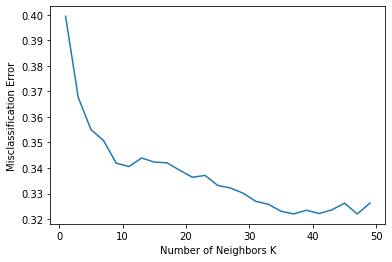

In [86]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [63]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_pca, y_train)
pred = knn.predict(X_val_pca)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 37

Optimal accuracy on the test set is 0.6880165289256198 with k= 37


In [89]:
pca = PCA().fit(X_train_sfm)
X_train_pca = pca.transform(X_train_sfm)
X_val_pca = pca.transform(X_val_sfm)

In [90]:
import time

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_pca, y_train)
# val_score = estimator.score(X_val, y_val)

preds = estimator.predict(X_val_pca)
val_score = estimator.score(X_val_pca, y_val)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 42.792473554611206 seconds
              precision    recall  f1-score   support

   home_loss       0.65      0.51      0.58      1011
    home_win       0.70      0.81      0.75      1409

    accuracy                           0.68      2420
   macro avg       0.68      0.66      0.66      2420
weighted avg       0.68      0.68      0.68      2420

val score: 0.6834710743801653
KNeighborsClassifier(leaf_size=1, n_neighbors=47)
{'leaf_size': 1, 'n_neighbors': 47}
best score: 0.6772463768115942
test score 0.6545454545454545


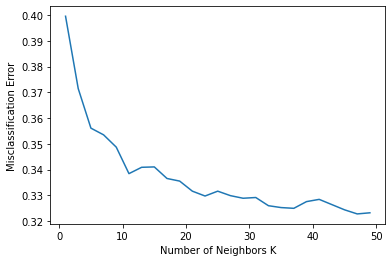

In [91]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [92]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_pca, y_train)
pred = knn.predict(X_val_pca)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 47

Optimal accuracy on the test set is 0.6834710743801653 with k= 47


In [101]:
pca = PCA(n_components=10).fit(X_train_for_sfs)
X_train_pca = pca.transform(X_train_for_sfs)
X_val_pca = pca.transform(X_val_for_sfs)

In [102]:
import time

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_pca, y_train)
# val_score = estimator.score(X_val, y_val)

preds = estimator.predict(X_val_pca)
val_score = estimator.score(X_val_pca, y_val)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 44.33962368965149 seconds
              precision    recall  f1-score   support

   home_loss       0.66      0.52      0.58      1011
    home_win       0.70      0.81      0.75      1409

    accuracy                           0.69      2420
   macro avg       0.68      0.66      0.67      2420
weighted avg       0.68      0.69      0.68      2420

val score: 0.6867768595041323
KNeighborsClassifier(leaf_size=1, n_neighbors=45)
{'leaf_size': 1, 'n_neighbors': 45}
best score: 0.6792753623188406
test score 0.6545454545454545


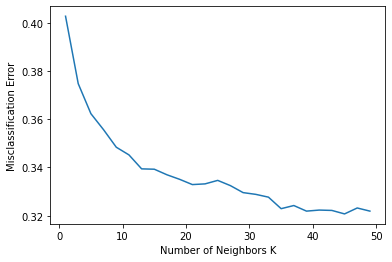

In [103]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [104]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_pca, y_train)
pred = knn.predict(X_val_pca)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 45

Optimal accuracy on the test set is 0.6867768595041323 with k= 45


In [111]:
pca = PCA(n_components=10).fit(X_train_back_sfs)
X_train_pca = pca.transform(X_train_back_sfs)
X_val_pca = pca.transform(X_val_back_sfs)

In [112]:
import time

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_pca, y_train)
# val_score = estimator.score(X_val, y_val)

preds = estimator.predict(X_val_pca)
val_score = estimator.score(X_val_pca, y_val)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 42.89442777633667 seconds
              precision    recall  f1-score   support

   home_loss       0.66      0.52      0.58      1011
    home_win       0.70      0.81      0.75      1409

    accuracy                           0.69      2420
   macro avg       0.68      0.66      0.67      2420
weighted avg       0.68      0.69      0.68      2420

val score: 0.6880165289256198
KNeighborsClassifier(leaf_size=1, n_neighbors=49)
{'leaf_size': 1, 'n_neighbors': 49}
best score: 0.6779710144927537
test score 0.6545454545454545


### Choose some features without Feature Selection

In [121]:
X_train_demo = train_data[['odds_home', 'odds_away', 'diff_of_odds', 'diff_win_pct_3_last_games',
                    'diff_win_pct_7_last_games', 'diff_curr_away_record', 'diff_curr_home_record',
                    'diff_curr_win_pct']]
y_train_demo = y_train

X_val_demo = valid_data[['odds_home', 'odds_away', 'diff_of_odds', 'diff_win_pct_7_last_games', 
                    'diff_win_pct_3_last_games', 'diff_curr_away_record', 'diff_curr_home_record',
                    'diff_curr_win_pct']]
y_val_demo = y_val

In [122]:
# Scaling features
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train_demo)
X_val_minmax = scaler.transform(X_val_demo)
# X_test_minmax = scaler.transform(X_test)

In [123]:
import time

# Split Data to Train and Validation
# X_train, X_val, y_train, y_val = train_test_split(X_train_minmax, y_train, test_size=0.4)
clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 50),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_minmax, y_train)
val_score = estimator.score(X_val_minmax, y_val)

preds = estimator.predict(X_val_minmax)
# test_score = estimator.score(X_test_minmax, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
# print("test score", test_score)



Συνολικός χρόνος fit και predict: 68.1153814792633 seconds
              precision    recall  f1-score   support

   home_loss       0.63      0.57      0.60      1011
    home_win       0.71      0.76      0.73      1409

    accuracy                           0.68      2420
   macro avg       0.67      0.66      0.67      2420
weighted avg       0.68      0.68      0.68      2420

val score: 0.6797520661157025
KNeighborsClassifier(leaf_size=1, n_neighbors=40)
{'leaf_size': 1, 'n_neighbors': 40}
best score: 0.6717391304347826
